In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import shap
import tensorflow.keras.backend 
from matplotlib import pyplot
import matplotlib.pyplot as plt
shap.initjs()

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood a

In [2]:
import deeplift

# supress deprecation warnings from TF
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [38]:
from tensorflow.keras.models import model_from_json

#keras_model_weights = "final_model/keras2_conv1d.h5"
#keras_model_json = "final_model/keras2_conv1d.json"

keras_model_weights = "final_model/keras2_dnn.h5"
keras_model_json = "final_model/keras2_dnn.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model = tensorflow.keras.models.load_model(keras_model_weights)
keras_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 64)                1664      
_________________________________________________________________
dense_35 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_36 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_37 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_38 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 129       
Total params: 141,825
Trainable params: 141,825
Non-trainable params: 0
________________________________________________

In [6]:
train_set=read_csv('data/train_set.csv')
val_set=read_csv('data/val_set.csv')
test_set=read_csv('data/test_set.csv')

In [7]:
trainy=read_csv('data/trainy.csv')
valy=read_csv('data/valy.csv')
testy=read_csv('data/testy.csv')

In [8]:
df = read_csv('data/orginal_data.csv')

In [9]:
# make the range between 0 and 1
column = list(train_set.columns.values)
for col in column:
    minimum = df[col].min()
    maximum = df[col].max()
    train_set[col] = (train_set[col] - minimum)/(maximum-minimum)
    val_set[col] = (val_set[col] - minimum)/(maximum-minimum)
    test_set[col] = (test_set[col] - minimum)/(maximum-minimum)

In [10]:
train_set_cnn = train_set.values
val_set_cnn = val_set.values
test_set_cnn = test_set.values

In [11]:
train_set_cnn = np.reshape(train_set_cnn, (train_set_cnn.shape[0],train_set_cnn.shape[1],1))
val_set_cnn = np.reshape(val_set_cnn, (val_set_cnn.shape[0],val_set_cnn.shape[1],1))
test_set_cnn = np.reshape(test_set_cnn, (test_set_cnn.shape[0],test_set_cnn.shape[1],1))

In [39]:
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
from collections import OrderedDict

method_to_model = OrderedDict()
for method_name, nonlinear_mxts_mode in [
    #The genomics default = rescale on conv layers, revealcance on fully-connected
    ('rescale_conv_revealcancel_fc', NonlinearMxtsMode.DeepLIFT_GenomicsDefault),
    ('rescale_all_layers', NonlinearMxtsMode.Rescale),
    ('revealcancel_all_layers', NonlinearMxtsMode.RevealCancel),
    ('grad_times_inp', NonlinearMxtsMode.Gradient),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop)]:
    method_to_model[method_name] = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json,
        nonlinear_mxts_mode=nonlinear_mxts_mode)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault


The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


For layer 0 the preceding linear layer is preact_0 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 1 the preceding linear layer is preact_1 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 2 the preceding linear layer is preact_2 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 3 the preceding linear layer is preact_3 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 4 the preceding linear layer is preact_4 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an interm

In [40]:
######### sanity checks ########
from deeplift.util import compile_func
model_to_test = method_to_model['revealcancel_all_layers']
deeplift_prediction_func = compile_func([model_to_test.get_layers()[0].get_activation_vars()],
                                         model_to_test.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(test_set, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[test_set],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

maximum difference in predictions: 1.1920929e-07


In [41]:
revealcancel_model = method_to_model['revealcancel_all_layers']
grad_model = method_to_model['grad_times_inp']
guided_backprop_model = method_to_model['guided_backprop']
rescale_conv = method_to_model['rescale_conv_revealcancel_fc']
rescale_all = method_to_model['rescale_all_layers']

In [42]:
rescale_all.get_layers()

In [43]:
######## compute importance scores ##########
from keras import backend as K
import deeplift
from deeplift.util import get_integrated_gradients_function

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
revealcancel_fc = rescale_conv.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
revealcancel_all = rescale_all.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
#rescale_multiplier = rescale_all.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-1)

grad_times_inp_func = grad_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
guided_backprop_times_inp_func = guided_backprop_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)


#To get a function that just gives the gradients, we use the multipliers of the Gradient model
gradient_func = grad_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)

#pure-gradients or pure-guidedbackprop perform rather poorly because they produce scores on pixels that are 0 (which are
#the backround in MNIST). But we can give them a slight advantage by masking out positions that
#are zero. Also, the method of simonyan et al uses the magnitude of the gradient.


#prepare the integrated gradients scoring functions
#heads-up: these take 5x and 10x longer to compute respectively!
integrated_grads_5 = get_integrated_gradients_function(gradient_func, 5)
integrated_grads_10 = get_integrated_gradients_function(gradient_func, 10)

In [44]:
gradient_multiplier = np.array(gradient_func(task_idx=0,
                                         input_data_list=[test_set],
                                         batch_size=10,
                                         progress_update=10000))

No reference provided - using zeros
Done 0
Done 10000


In [45]:
gradient_multiplier.shape

(19584, 25)

In [46]:
from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
print("HEADS UP! integrated_grads_5 and integrated_grads_10 take 5x and 10x longer to run respectively")
print("Consider leaving them out to get faster results")
for method_name, score_func in [
                               ('rescale_conv_revealcancel_fc', revealcancel_fc),
                               ('revealcancel', revealcancel_func),
                               ('rescale_all_layers',revealcancel_all),
                               ('guided_backprop_times_inp', guided_backprop_times_inp_func),
                               
                               ('grad_times_inp', grad_times_inp_func)
                              
]:
    print("Computing scores for:",method_name)
    method_to_task_to_scores[method_name] = {}
    for task_idx in range(1):
        print("\tComputing scores for task: "+str(task_idx))
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[test_set],
                    input_references_list=[np.zeros_like(test_set)],
                    batch_size=1000,
                    progress_update=None))
        method_to_task_to_scores[method_name][task_idx] = scores

HEADS UP! integrated_grads_5 and integrated_grads_10 take 5x and 10x longer to run respectively
Consider leaving them out to get faster results
Computing scores for: rescale_conv_revealcancel_fc
	Computing scores for task: 0
Computing scores for: revealcancel
	Computing scores for task: 0
Computing scores for: rescale_all_layers
	Computing scores for task: 0
Computing scores for: guided_backprop_times_inp
	Computing scores for task: 0
Computing scores for: grad_times_inp
	Computing scores for task: 0


In [47]:
scores = method_to_task_to_scores['revealcancel']
scores1 = method_to_task_to_scores['rescale_conv_revealcancel_fc']
scores2 = method_to_task_to_scores['rescale_all_layers']
scores3 = method_to_task_to_scores['guided_backprop_times_inp']
scores4 = method_to_task_to_scores['grad_times_inp']

In [25]:
####### for the cnn model #######
importance_score = np.reshape(scores[0], (scores[0].shape[0], scores[0].shape[1]))
importance_score1 = np.reshape(scores1[0], (scores1[0].shape[0], scores1[0].shape[1]))
importance_score2 = np.reshape(scores2[0], (scores2[0].shape[0], scores2[0].shape[1]))
importance_score3 = np.reshape(scores3[0], (scores3[0].shape[0], scores3[0].shape[1]))
importance_score4 = np.reshape(scores4[0], (scores4[0].shape[0], scores4[0].shape[1]))


In [48]:
###### this time the score is for the dnn model#######
importance_score_dnn = scores[0]
importance_score1_dnn = scores1[0]
importance_score2_dnn = scores2[0]
importance_score3_dnn = scores3[0]
importance_score4_dnn = scores4[0]

In [24]:
#shap explanation##########

In [49]:
#background = np.zeros((1,25,1))
background = np.zeros((1,25))

In [50]:
test_set.shape

(19584, 25)

In [52]:
# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(keras_model,  background)
shap_values = explainer.shap_values(test_set)
#sample_phis = explainer.sample_phis(test_set)

In [ ]:
importance_shap = np.reshape(shap_values[0], (shap_values[0].shape[0], shap_values[0].shape[1]))

In [53]:
importance_shap_dnn = np.reshape(shap_values[0], (shap_values[0].shape[0], shap_values[0].shape[1]))

In [36]:
importance_shap.shape

(19584, 25)

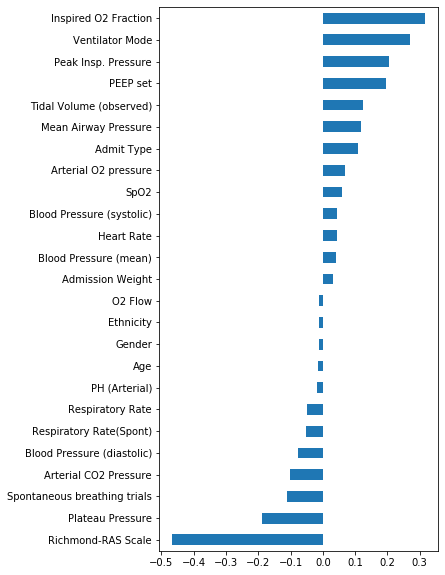

In [34]:
######### cnn improtance using shap ######
ave_shap= np.mean(importance_shap, axis = 0)
ave_shap = np.round(ave_shap, 4)
ave_shap = pd.Series(ave_shap, index=['Admit Type', 'Ethnicity', 'Gender', 'Age', 'Admission Weight',
       'Heart Rate', 'Respiratory Rate', 'SpO2',
       'Inspired O2 Fraction', 'PEEP set', 'Mean Airway Pressure',
       'Tidal Volume (observed)', 'PH (Arterial)',
       'Respiratory Rate(Spont)', 'Richmond-RAS Scale',
       'Peak Insp. Pressure', 'O2 Flow', 'Plateau Pressure',
       'Arterial O2 pressure', 'Arterial CO2 Pressure',
       'Blood Pressure (systolic)', 'Blood Pressure (diastolic)',
       'Blood Pressure (mean)', 'Spontaneous breathing trials', 'Ventilator Mode'])
ave_shap = ave_shap.sort_values(ascending=True)
ave_shap.plot(kind='barh', figsize=(5,10))
plt.show()

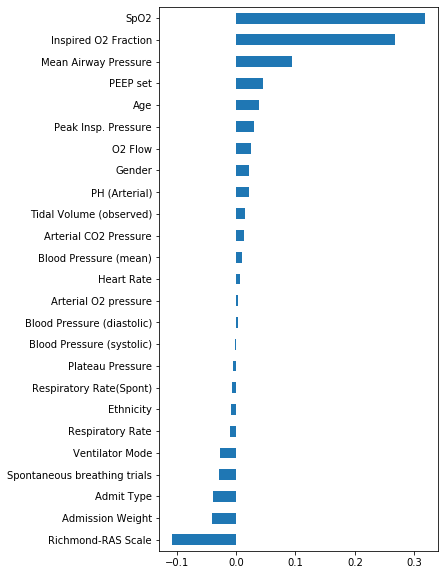

In [54]:
######### dnn improtance using shap ######
ave_shap= np.mean(importance_shap_dnn, axis = 0)
ave_shap = np.round(ave_shap, 4)
ave_shap = pd.Series(ave_shap, index=['Admit Type', 'Ethnicity', 'Gender', 'Age', 'Admission Weight',
       'Heart Rate', 'Respiratory Rate', 'SpO2',
       'Inspired O2 Fraction', 'PEEP set', 'Mean Airway Pressure',
       'Tidal Volume (observed)', 'PH (Arterial)',
       'Respiratory Rate(Spont)', 'Richmond-RAS Scale',
       'Peak Insp. Pressure', 'O2 Flow', 'Plateau Pressure',
       'Arterial O2 pressure', 'Arterial CO2 Pressure',
       'Blood Pressure (systolic)', 'Blood Pressure (diastolic)',
       'Blood Pressure (mean)', 'Spontaneous breathing trials', 'Ventilator Mode'])
ave_shap = ave_shap.sort_values(ascending=True)
ave_shap.plot(kind='barh', figsize=(5,10))
plt.show()

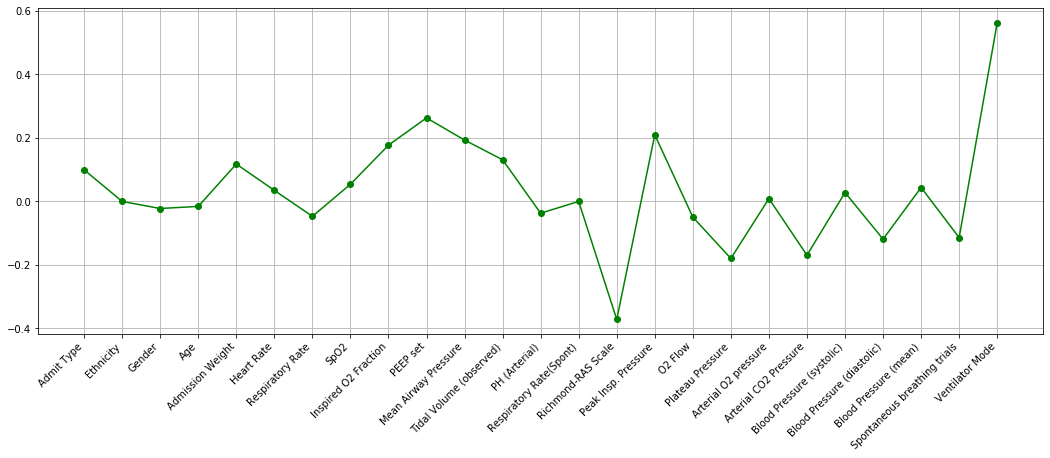

In [37]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))
plt.plot(importance_shap[124], 'go-')
#plt.plot([0, 25],[0,0], '--',linewidth=1)
plt.grid(True)
plt.xticks(np.arange(25),
          ['Admit Type', 'Ethnicity', 'Gender', 'Age', 'Admission Weight',
       'Heart Rate', 'Respiratory Rate', 'SpO2',
       'Inspired O2 Fraction', 'PEEP set', 'Mean Airway Pressure',
       'Tidal Volume (observed)', 'PH (Arterial)',
       'Respiratory Rate(Spont)', 'Richmond-RAS Scale',
       'Peak Insp. Pressure', 'O2 Flow', 'Plateau Pressure',
       'Arterial O2 pressure', 'Arterial CO2 Pressure',
       'Blood Pressure (systolic)', 'Blood Pressure (diastolic)',
       'Blood Pressure (mean)', 'Spontaneous breathing trials', 'Ventilator Mode'], rotation=45,horizontalalignment='right', multialignment='center')
plt.show()